# **Analysis of the Rome housing market**

In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
from scipy.stats import norm

from matplotlib import pyplot as plt
from PIL import Image
import seaborn as sns

sns.set(style='whitegrid')
pd.options.display.float_format = '{:,.2f}'.format

# Data cleaning and single variable exploration

## Error rates

Of course no scraper is perfect, and the one I made was no exception. I took care of logging the errors made, keeping track of the insertion number and the field that could not be retrieved correctly.

In [2]:
with open('data/immobiliare_errors.csv', 'r') as error_file:
    error_log = pd.read_csv(error_file, header=None, names=['id', 'field'])
error_log.head(8)

,id,field
0,6,energy_rating
1,7,house_type
2,10,house_type
3,10,energy_rating
4,12,house_type
5,14,energy_rating
6,16,house_type
7,18,house_type


Plotting the error frequency. Roughly one fourth of the data has no valid entry for `energy_rating` or `house_type`, but luckily important entries such as `price` or `rooms` have error rates below 5%.

Text(0, 0.5, '')

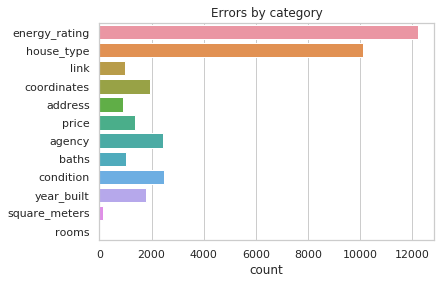

In [3]:
err_ax = sns.countplot(y='field', data=error_log)
err_ax.set_title('Errors by category')
err_ax.set_ylabel('')

## General information about the dataset

In [4]:
with open('data/immobiliare_data_raw.csv', 'r') as data_file:
    data = pd.read_csv(data_file)

In [5]:
print("(Rows, Columns) =", data.shape)

(Rows, Columns) = (41900, 13)


The data scraped from [immobiliare.it](https://www.immobiliare.it/) looks like this.

In [6]:
data.head(10)

,address,price,square_meters,rooms,baths,floor,type,year_built,condition,energy_rating,longitude,latitude,agency
0,"via Anneo Lucano 42, Roma",630000,144,4,3,4,Appartamento,1967,Ottimo/Ristrutturato,E,41.92,12.44,RE/MAX Abacus
1,"via dei Colli della Farnesina 72, Roma",1090000,198,5,3,4,Appartamento,1966,Ottimo / Ristrutturato,E,41.94,12.45,RE/MAX Abacus
2,"viale Pola, Roma",1200000,208,5,3,0,Appartamento,1956,Buono / Abitabile,F,41.64,12.44,KELLER WILLIAMS
3,NaN,690000,103,4,1,4,Attico,1935,Ottimo / Ristrutturato,F,44.93,7.54,Engel & Völkers Roma • Market Center
4,"via Vincenzo Troya, Roma",239000,90,3,1,0,Appartamento,1960,Buono / Abitabile,G,41.94,12.42,Bovi RE
5,"via del Moro 23, Roma",370000,66,3,1,2,Appartamento,1500,Ottimo / Ristrutturato,G,41.89,12.47,Coldwell Banker Exclusive RE
6,"via Dobbiaco 10, Roma",179000,59,2,1,1,Appartamento,NaN,€ 50/mese,0,41.74,12.38,Colossea
7,"via Bersone, Roma",349000,218,4,3,-2,NaN,2007,Ottimo / Ristrutturato,F,41.73,12.37,Colossea
8,"via Ostiense 85, Roma",419000,93,3,3,1,Appartamento,1960,Ottimo/Ristrutturato,G,41.87,12.48,Bovi RE
9,"viale Parioli, Roma",1250000,150,4,2,3,Appartamento,1952,Da ristrutturare,G,41.93,12.48,Coldwell Banker Exclusive RE


In [7]:
data.describe()

,price,square_meters,rooms,baths,floor,longitude,latitude
count,"41,900.00","41,900.00","41,900.00","41,900.00","41,900.00","41,900.00","41,900.00"
mean,"63,991,840.06","6,396.85",4.62,4.82,9.45,41.08,11.78
std,"4,153,319,427.70","32,590.06",35.82,31.01,27.66,6.64,2.90
min,0.00,0.00,0.00,0.00,-2.00,-32.81,-117.65
25%,"175,000.00",70.00,2.00,1.00,-1.00,41.83,12.38
50%,"260,000.00",97.00,3.00,2.00,1.00,41.89,12.47
75%,"419,000.00",143.00,4.00,2.00,3.00,41.94,12.55
max,"418,000,540,000.00","310,120.00","2,500.00","3,288.00",100.00,51.93,121.44


In [8]:
data.dtypes

address           object
price              int64
square_meters      int64
rooms              int64
baths              int64
floor              int64
type              object
year_built        object
condition         object
energy_rating     object
longitude        float64
latitude         float64
agency            object
dtype: object

Now we'll start exploring the varibles and cleaning them, from right to left.

## Agency

There are 2416 listed agencies.


Text(0.5, 1.0, 'Agencies Counts')

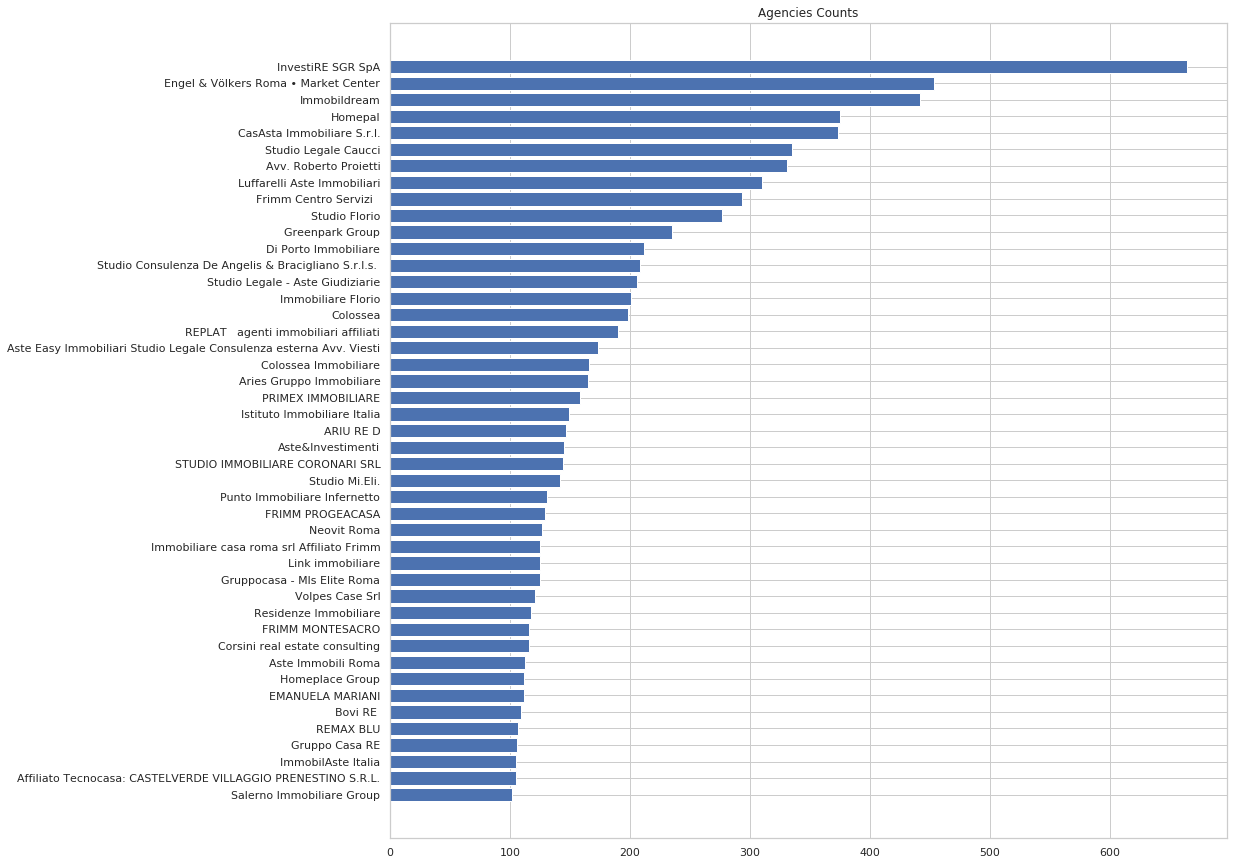

In [9]:
agencies = data.agency.value_counts().sort_values(ascending=True)
print("There are", len(agencies), "listed agencies.")
agencies = agencies[agencies > 100]

plt.figure(figsize=(15,15))
plt.barh(width=agencies, y=agencies.index)
plt.title('Agencies Counts')

## Coordinates

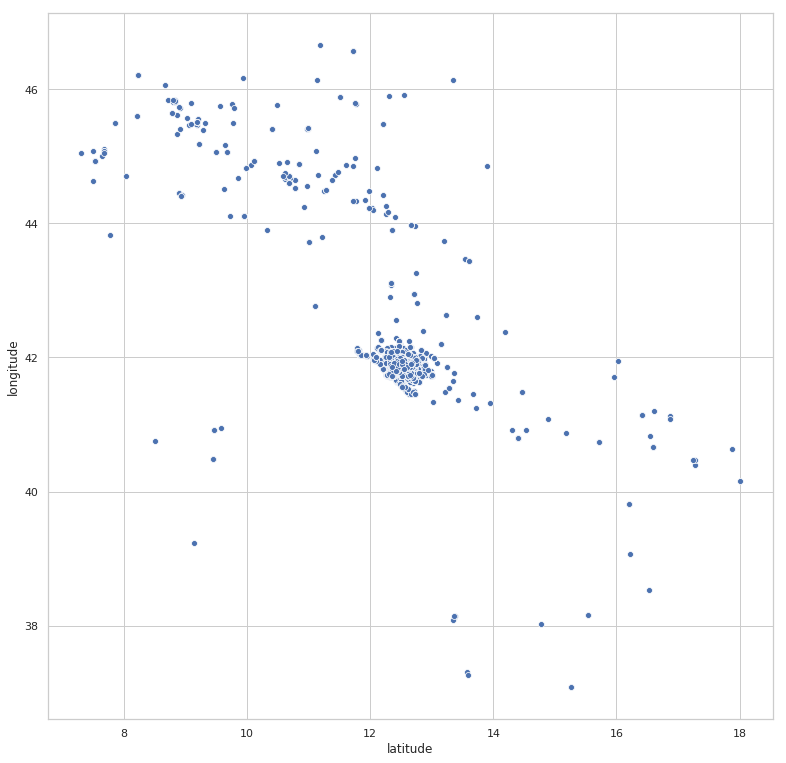

In [10]:
coord_data = data.loc[
    (data.latitude < 25) & 
    (data.latitude > 4) & 
    (data.longitude < 48) & 
    (data.longitude > 35)
]

plt.figure(figsize=(13,13))
sns.scatterplot(
    x='latitude',
    y='longitude',
    data=coord_data
)

## Energy ratings

In [11]:
# entries having some text trailing
energy_class_begin_regex = re.compile('[A-G][1-4\+]?,.+')
dirty_energy_data = data.energy_rating.loc[
    data.energy_rating.str.contains(energy_class_begin_regex)
]
dirty_energy_data.head()

585    A1, edificio energia quasi zero
628    A2, edificio energia quasi zero
695    A2, edificio energia quasi zero
724    A1, edificio energia quasi zero
735    A2, edificio energia quasi zero
Name: energy_rating, dtype: object

In [12]:
# cleaning data - part 1
take_energy = lambda s: s.split(',')[0]
data.energy_rating.iloc[dirty_energy_data.index] = dirty_energy_data.apply(take_energy)

# getting numerical energy formats
other_energy_formats = data.energy_rating.loc[data.energy_rating.str.contains('.*[1-9].*kWh/m²a')]
print("There are", len(other_energy_formats), "entries of type:")
print(other_energy_formats.head(10))

There are 6652 entries of type:
247    ≥ 3,51 kWh/m²a
248    175,00 kWh/m²a
250    175,00 kWh/m²a
253    119,00 kWh/m²a
260    175,00 kWh/m²a
395    175,00 kWh/m²a
422    175,00 kWh/m²a
426    175,00 kWh/m²a
427    175,00 kWh/m²a
428    175,00 kWh/m²a
Name: energy_rating, dtype: object


/home/jonny/.local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


![alt text](assets/classe-energetica.jpg)

In [13]:
energy_tr = {
    10: 'A+',
    30: 'A',
    50: 'B',
    70: 'C',
    90: 'D',
    120:'E',
    160: 'F',
    1000: 'G'
}

get_number = lambda s: int(re.compile('[1-9]+').findall(s)[0])
get_class = lambda s: energy_tr[min([n for n in energy_tr.keys() if n >= get_number(s)])]

data.energy_rating.iloc[other_energy_formats.index] = other_energy_formats.apply(get_class)

Text(0.5, 1.0, 'Energy Classes Counts')

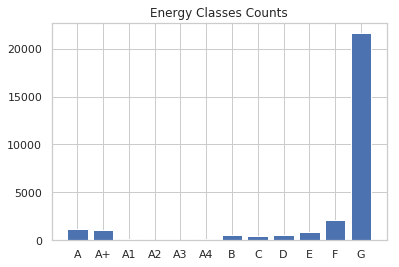

In [14]:
# entries exactly matching an energy rating
energy_class_regex = re.compile('[A-G][1-4\+]?$')
energy_data = data.energy_rating.loc[data.energy_rating.str.match(energy_class_regex)]

energy_hist = energy_data.value_counts()
energy_hist = energy_hist.sort_index()

plt.bar(x=energy_hist.index, height=energy_hist)
plt.title('Energy Classes Counts')

Text(0.5, 1.0, 'Energy ratings (As bundled together)')

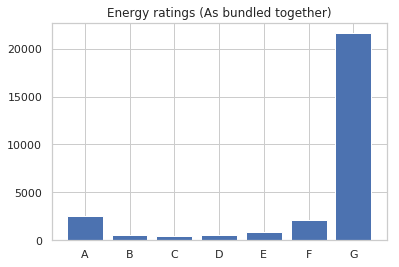

In [15]:
# bundling As together
energy_A = re.compile('A')
energy_hist['A'] = energy_hist.loc[energy_hist.index.str.match(energy_A)].sum()
energy_hist = energy_hist.drop(['A+','A1','A2', 'A3', 'A4'])

plt.bar(x=energy_hist.index, height=energy_hist)
plt.title('Energy ratings (As bundled together)')

In [16]:
# percentages
energy_hist / energy_data.shape[0] * 100

A    8.77
B    1.91
C    1.62
D    1.95
E    3.08
F    7.51
G   75.16
Name: energy_rating, dtype: float64

## Condition and year built

- in alcune pagine non era indicata la tipologia della casa in un apposito campo, ma solo la classe catastale, 'A/2' e 'A/7' nei casi osservati, che corrispondono alle Ville e ai Villini
- in altre pagine la condizione dell'appartamento appariva nel campo solitamente destinato all'anno

Eliminiamo i due fenomeni.

In [19]:
types_list = [
    'Appartamento',
    'Attico',
    'Loft',
    'Open Space',
    'Mansarda',
    'Soffitta'
]

condition_list = [
    'Nuovo / In costruzione',
    'Nuovo/In costruzione'
    'Da ristrutturare',
    'Da ristrutturare',
    'Ottimo/Ristrutturato',
    'Ottimo / Ristrutturato',
    'Buono / Abitabile',
    'Buono/Abitabile'
]

wrong_apt_idxs = (
    (~data.type.isin(types_list)) &
    (data.condition.str.contains('Classe A/2'))
)
wrong_vil_idxs = (
    (~data.type.isin(types_list)) &
    (data.condition.str.contains('Classe A/7'))
)
wrong_year_idxs = (
    (~data.condition.isin(condition_list)) &
    (data.year_built.isin(condition_list))
)

wrong_apt_idxs = wrong_apt_idxs[wrong_apt_idxs].index
wrong_vil_idxs = wrong_vil_idxs[wrong_vil_idxs].index
wrong_year_idxs = wrong_year_idxs[wrong_year_idxs].index
        
print("Wrong Apartment entries:", len(wrong_apt_idxs))
print("Wrong house entries:", len(wrong_vil_idxs))
print("Wrong year entries:", len(wrong_year_idxs))

Wrong Apartment entries: 21
Wrong house entries: 51
Wrong year entries: 7938


Correggiamo gli errori.

In [20]:
data.loc[wrong_apt_idxs, 'type'] = 'Villa'
data.loc[wrong_apt_idxs,'condition'] = np.nan

data.loc[wrong_vil_idxs,'type'] = 'Villino'
data.loc[wrong_vil_idxs,'condition'] = np.nan

data.loc[wrong_year_idxs,'condition'] = data.loc[wrong_year_idxs,'year_built']
data.loc[wrong_year_idxs,'year_built'] = np.nan

In [22]:
data.loc[data.condition == 'Ottimo/Ristrutturato', 'condition'] = 'Ottimo / Ristrutturato'

Text(0.5, 0, '')

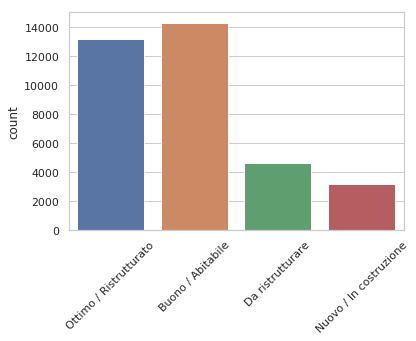

In [23]:
conditions = data.condition.loc[data.condition.isin(condition_list)]

condtion_ax = sns.countplot(conditions)
condtion_ax.set_xticklabels(condtion_ax.get_xticklabels(), rotation=45)
condtion_ax.set_xlabel('')

In [24]:
print(data.condition.loc[~data.index.isin(conditions.index)].head(30))

6                          € 50/mese
10                               NaN
14                         € 50/mese
18                               NaN
27                               NaN
30     Classe A/7, rendita € 159.000
41                               NaN
64                         € 70/mese
71                               NaN
72                               NaN
75                               NaN
76                               NaN
85                               NaN
89                        € 300/anno
93                         € 70/mese
95     Classe A/7, rendita € 169.000
104                              NaN
106                              NaN
113                              NaN
118                              NaN
126                              NaN
129                              NaN
133                        € 40/mese
135                              NaN
136                              NaN
157                              NaN
176                              NaN
1

Text(0.5, 0, 'Decade')

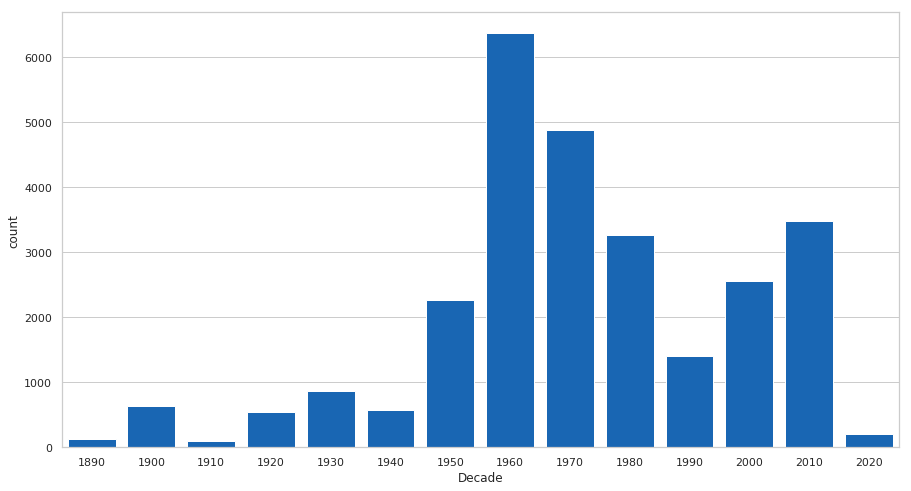

In [25]:
year_re = re.compile('\d{4}')
years = data.year_built[(~data.year_built.isnull()) & (data.year_built.str.match(year_re))]
years = years.apply(lambda s: s[:3] + '0') #+ str((int(s[3]) // 5) * 5)) # 5 year chunks

plt.figure(figsize=(15,8))
year_ax = sns.countplot(x=years[years.astype(int) > 1880], color='#0066cc')
year_ax.set_xlabel('Decade')

## Rooms and Bathrooms

Text(0.5, 0, '')

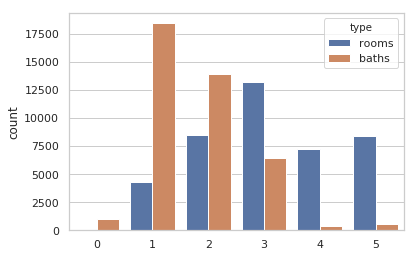

In [26]:
roombath_df = pd.concat([
    pd.DataFrame({
        'count': data.rooms[data.rooms < 6],
        'type': 'rooms'
    }),
    pd.DataFrame({
        'count': data.baths[data.baths < 6],
        'type': 'baths'
    })
])

roombath_ax = sns.countplot(x='count', hue='type', data=roombath_df)
roombath_ax.set_xlabel('')

## Square meters

/home/jonny/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


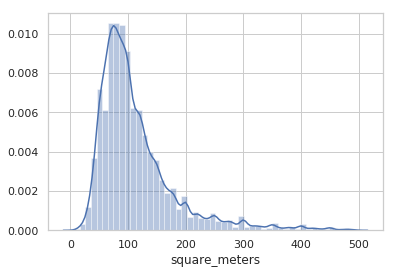

In [27]:
square_meters = data.square_meters[(data.square_meters < 5e+2) & (data.square_meters > 5.)]
sns.distplot(square_meters)

Text(0.5, 0, 'log(square_meters)')

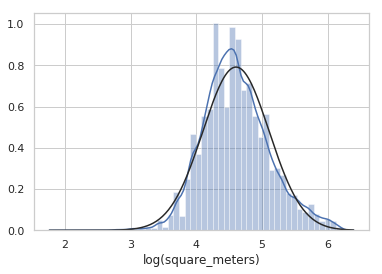

In [28]:
log_square_meters = np.log1p(square_meters.values)
log_sqm_ax = sns.distplot(log_square_meters, fit=norm)
log_sqm_ax.set_xlabel('log(square_meters)')

## Price

In [29]:
prices = data['price']

print(f"There are {len(prices.loc[prices == 0])} entries with price=0€")

prices = prices.loc[prices > 1e+4]

There are 461 entries with price=0€


In [30]:
fake_outliers = prices.loc[prices > 1e+8]
print(f"There are {len(fake_outliers)} houses with prices above 100 million €")
print("\n\nHere they are:")
fake_outliers

There are 11 houses with prices above 100 million €


Here they are:


682      168000524000
701      186000894000
953      169000179000
1120     289000323000
7365     139000252000
7939     161158236132
8204     340000390000
8442     283988798088
9027     418000540000
18390    280000780000
25605    231000693000
Name: price, dtype: int64

In [31]:
bad_indices = [682, 701, 7365, 7939, 8442, 18390, 25605]
prices = prices.drop(index=bad_indices)

fake_outliers = fake_outliers.drop(index=bad_indices)

fake_outliers.loc[953] = (169000 + 179000) / 2
fake_outliers.loc[1120] = (289000 + 323000) / 2
fake_outliers.loc[8204] = (340000 + 390000) / 2
fake_outliers.loc[9027] = (418000 + 540000) / 2

prices.loc[fake_outliers.index] = fake_outliers
data.loc[fake_outliers.index].price = fake_outliers

Since we're not trying to explore the luxurious house market, but rather the standard one for laypeople, we'll drop houses priced at more than 2 million € for this analysis.

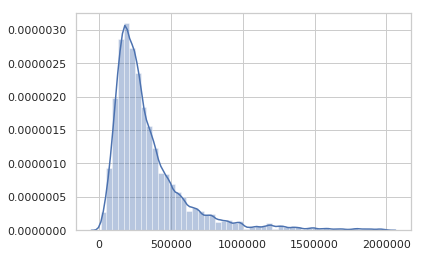

In [32]:
prices = prices.loc[prices < 2e+6]
sns.distplot(prices.values)

In [33]:
print("Price Mean: {:.2f}".format(prices.mean()))
print("Price Median: {:.2f}".format(prices.median()))
print("Price Std: {:.2f}".format(prices.std()))

Price Mean: 341686.42
Price Median: 260000.00
Price Std: 271519.91


Text(0.5, 0, 'log(price)')

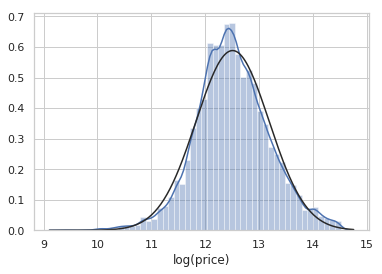

In [34]:
log_prices = np.log1p(prices.values)
price_ax = sns.distplot(log_prices, fit=norm)
price_ax.set_xlabel('log(price)')

# Price VS Coordinates

In [ ]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV


kde_bands = np.logspace(-2.5, 0.25, 20)
params = {'bandwidth': kde_bands}
grid = GridSearchCV(KernelDensity(), params, cv=5)
grid.fit(log_prices.values.reshape(-1,1))

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(kde_bands, grid.cv_results_['mean_test_score'])
ax[0].title.set_text('Cross Validation Score')

eval_pts = np.linspace(10, 15, 60)
ax[1].plot(eval_pts, np.exp(grid.best_estimator_.score_samples(eval_pts.reshape(-1,1))))
ax[1].title.set_text('Estimated Density')

plt.show()

In [ ]:
# selecting relevant columns for price analysis
data_coords = data[['latitude', 'longitude']]
data_coords = data_coords.loc[data.type == 'Appartamento']
data_coords['price_sqm'] = data.price / data.square_meters

# discarding isolated, 'rural' houses
#data_coords = data_coords.loc[
#    (data_coords.latitude > data_coords.latitude.quantile(0.15)) & 
#    (data_coords.latitude < data_coords.latitude.quantile(0.9)) & 
#    (data_coords.longitude > data_coords.longitude.quantile(0.15)) & 
#    (data_coords.longitude < data_coords.longitude.quantile(0.9))
#]

bg = Image.open('screenshot_roma.png')
bg_x_span = np.r_[12.160484, 12.751934]
bg_y_span = np.r_[41.658783, 42.023778]

data_coords = data_coords.loc[
    (data_coords.latitude > bg_x_span[0]) & 
    (data_coords.latitude < bg_x_span[1]) & 
    (data_coords.longitude > bg_y_span[0]) & 
    (data_coords.longitude < bg_y_span[1])
]

# normalizing coordinates
coord_means = data_coords.mean()
coord_stds = data_coords.std()

data_coords['latitude'] = (data_coords.latitude - coord_means.latitude) / coord_stds.latitude
data_coords['longitude'] = (data_coords.longitude - coord_means.longitude) / coord_stds.longitude

bg_x_span = (bg_x_span - coord_means.latitude) / coord_stds.latitude
bg_y_span = (bg_y_span - coord_means.longitude) / coord_stds.longitude

In [ ]:
# cross validating KDE
kde_bands = np.logspace(-2, 1, 20)
params = {'bandwidth': kde_bands}
grid = GridSearchCV(KernelDensity(), params, cv=5)
grid.fit(data_coords.iloc[:5000][['latitude', 'longitude']])
kde = grid.best_estimator_

# plotting cv score
plt.plot(kde_bands, grid.cv_results_['mean_test_score'])
plt.show()

In [ ]:
# plotting desity estimation
fig, ax = plt.subplots(1,1)

resolution = 100
x = np.linspace(data_coords.latitude.min(), data_coords.latitude.max(), resolution)
y = np.linspace(data_coords.longitude.min(), data_coords.longitude.max(), resolution)
X, Y = np.meshgrid(x,y)
Z = kde.score_samples(np.vstack([X.ravel(),Y.ravel()]).T)
Z = np.exp(Z.reshape(X.shape))

levels = np.linspace(Z.min(), Z.max(), 50)
ax.contourf(X, Y, Z, levels=levels, cmap=plt.cm.seismic)
plt.show()

In [ ]:
data_coords = data_coords.loc[(data_coords.price_sqm > 0) & (data_coords.price_sqm < 7000)]

gaussian = lambda x,sg: np.exp(- 0.5 * x / sg ** 2)
#1. / (2 * np.pi) / sg ** 2 *

def nadaraya_watson_kr (dx, dy, dz, ex, ey, kernel, bandwidth):
    dX, eX = np.meshgrid(dx, ex)
    dY, eY = np.meshgrid(dy, ey)
    
    K = kernel((dX - eX) ** 2 + (dY - eY) ** 2, bandwidth)
    return np.dot(K, dz) / K.sum(axis=1)

predictions = nadaraya_watson_kr (
    dx=data_coords['latitude'],
    dy=data_coords['longitude'],
    dz=data_coords['price_sqm'],
    ex=X.ravel(),
    ey=Y.ravel(),
    kernel=gaussian,
    bandwidth=0.045
)

In [ ]:
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.8, N+4)
    return mycmap

#predictions[predictions > 5700.] = 0.
plt.figure(figsize=(15,15))
levels = np.linspace(predictions.min(), predictions.max(), 50)
plt.imshow(bg, extent=tuple(np.r_[bg_x_span, bg_y_span]))
plt.contourf(X, Y, predictions.reshape(X.shape), levels=levels, cmap=transparent_cmap(plt.cm.Reds))
plt.colorbar()
plt.show()